In [123]:
import datetime
import tarfile
import json
import bz2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Filtering tweets from monthly .tar files

In [2]:
#keywords to filter the tweets
keywords=['gmo','gmos','gm food','gm foods','transgenic', 'transgenics','genetically-modified','genetically modified']

# initializing array which will hold the filtered tweets
filteredTweets=[]


# opening the tar file
with tarfile.open('data/TweetsDS.tar', 'r') as tar:
    
    # iterating through all files and directories
    for member in tar.getmembers():
        
        #skipping directories
        if member.isdir():
            continue
        
        #looking for the target files json.bz2
        if member.name.endswith('.json.bz2'):
            
            # extracting each file
            file = tar.extractfile(member)
         
            #reading in and decompressing the file
            noBz2 = bz2.decompress(file.read()).decode('utf-8')
            
            # handling each tweet to find the match
            for line in noBz2.splitlines():
                
                #each line is one tweet in json format, therefore loading line by line
                tweet = json.loads(line)

                # making sure the tweet has the fields 'text' and 'created_at'. If not they'll be skipped
                if 'text' not in tweet or 'created_at' not in tweet or tweet['user']['lang'] != 'en':
                    continue

                # Skipping retweets
                if tweet['text'].startswith('RT') and tweet.get('retweeted_status') is not None:
                    continue
                
                # storing fields if present
                tweetTxt = tweet['text']
                created_at = tweet['created_at']

                # Searching matches in text, splitting by words, lower case like keywords
                if any(keyword in tweetTxt.lower().split() for keyword in keywords):                
                    # Add the matching tweet to the list
                    filteredTweets.append({
                        'text': tweetTxt,
                        'created_at': created_at
                    })
                    

                    
#writting the fields from matching tweets to a json output file
with open('myTweets.json', 'w') as output:
    json.dump(filteredTweets, output)

In [117]:
from pyspark.sql.types import *
from pyspark.sql.functions import udf, desc
from pyspark.sql.types import TimestampType
from pyspark.sql import functions as F

In [4]:
sc

<SparkContext master=local[*] appName=PySparkShell>

### Loading data files to pyspark

In [69]:
#funtion to convert to time stamp with udf
def parseDate(date_str):
    return datetime.datetime.strptime(date_str, '%a %b %d %H:%M:%S %z %Y')

parse_date_udf= udf(parseDate, TimestampType())

#reading in the monthly json files
tweets= spark.read.json('hdfs://localhost:9000/user1/tweet*.json')

# applying udf to column
tweets= tweets.withColumn('created_at', parse_date_udf(tweets['created_at']))

#sorting by timestamp
tweets= tweets.orderBy('created_at')

tweets.printSchema();tweets.show()

root
 |-- created_at: timestamp (nullable = true)
 |-- text: string (nullable = true)

+-------------------+--------------------+
|         created_at|                text|
+-------------------+--------------------+
|2012-01-02 20:09:42|USDA has settled ...|
|2012-01-03 02:41:36|Sounds INSANE. GM...|
|2012-01-03 06:57:08|Petition: Tell th...|
|2012-01-03 12:30:19|Mandatory GMO foo...|
|2012-01-03 14:11:44|http://t.co/TI9oL...|
|2012-01-03 16:10:27|Want to learn mor...|
|2012-01-03 17:53:55|Safety assessment...|
|2012-01-03 18:30:38|GMO labeling effo...|
|2012-01-03 20:04:57|Leaked: US to Sta...|
|2012-01-04 00:22:12|Leaked: US to Sta...|
|2012-01-04 13:37:46|@IPIMCIMCIM  GMOs...|
|2012-01-05 02:42:31|@Kaybaebaeeee gmo...|
|2012-01-05 06:10:28|Apel ws. legislac...|
|2012-01-05 09:36:54|Woman files class...|
|2012-01-05 16:14:15|Leaked: US to Sta...|
|2012-01-05 17:42:20|@harjxo GMO twidd...|
|2012-01-05 19:42:18|@songbirdtiff Yup...|
|2012-01-05 21:07:46|Label GMO food ca...|
|2012-01-0

In [70]:
# number of rows
tweets.count()

3981

In [71]:
#sample
tweets.take(1)

[Row(created_at=datetime.datetime(2012, 1, 2, 20, 9, 42), text='USDA has settled upon a superb solution: let the GMO industry conduct its own environmental impact tests. http://t.co/Ed5BbDRb')]

## Duplicates

In [73]:
#grouping by text and counting them
duplicates= tweets.groupBy('text').count()

# filtering the rows with count >= 2 
duplicates= duplicates.filter(duplicates['count'] > 1)

duplicates.show()

+--------------------+-----+
|                text|count|
+--------------------+-----+
|People power caus...|    2|
|We are helping cu...|    2|
|At Disney World's...|    2|
|#USDA to Give #Mo...|    2|
|good going Boulde...|    2|
|STOP MONSANTO FRO...|    2|
|#Hungary Destroys...|    2|
|                 GMO|    2|
|Just played: GMO ...|    3|
|Mommy, what does ...|    2|
|Healthy Budget: G...|    5|
|Tell .@BarackObam...|    2|
|GMO updates,Femal...|    2|
|Healthy Budget: G...|    4|
|Pesticide Use Ram...|    2|
+--------------------+-----+



In [74]:
#viewing duplicates fully
duplicates.select('text').show(truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------+
|text                                                                                                                                        |
+--------------------------------------------------------------------------------------------------------------------------------------------+
|People power causes GMO firm to move from Europe to the US. http://t.co/TSaxGffw #GMOs #geneticallymodified #health                         |
|We are helping customers and team members get informed about GMOs via our in-store info centers. Visit one in our stores today.             |
|At Disney World's exhibit, teaching children about GMO agriculture is a "fun activity" http://t.co/EOKSqbGh @TrueFoodAust @TransitionSyd    |
|#USDA to Give #Monsanto’s New GMO Crops Special ‘Speed Approval’: If you thought Monsanto’s lack of testing on their... http://t.co/OzPr4jmL|

In [75]:
tweets.count()

3981

In [76]:
#dropping duplicates, keeping the oldest only
tweets= tweets.dropDuplicates(subset=['text'])

In [77]:
tweets.count()

3960

### Dates without tweets (~missing dates)

In [78]:
from pyspark.sql.functions import min, max, date_format, expr, hour
from pyspark.sql.types import DateType

In [103]:
# oldest and latest dates in df
oldestDate= tweets.select(min('created_at')).first()[0].date()
latestDate= tweets.select(max('created_at')).first()[0].date()

print(' Between\n',oldestDate,'\n and\n',latestDate,'\n')


#converting dates to Unix timestamps -> int() cannot be datetime.date
oldestDate= int(oldestDate.strftime("%s"))
latestDate= int(latestDate.strftime("%s"))

#generating the list of dates. 86400 s/day
timeRange= spark.range(start=oldestDate, end=latestDate, step=86400).selectExpr("to_date(from_unixtime(id)) as date")



#Listing missing dates with anti-join between the date range and the 'created_at' column. 
missingDates= timeRange.join(tweets, timeRange.date == tweets.created_at.cast(DateType()), 'leftanti') # leftanti selects the rows from the left df that do not have a matching key from the right df


print(" there are missing dates->",missingDates.count());missingDates.show()

 Between
 2012-01-02 
 and
 2013-03-01 

 there are missing dates-> 5
+----------+
|      date|
+----------+
|2012-02-05|
|2012-12-28|
|2012-12-29|
|2012-12-30|
|2012-12-31|
+----------+



In [36]:
##count per minute
# minutesDiff= int(spark.sql(f"SELECT CEIL((UNIX_TIMESTAMP('{maxDate}') - UNIX_TIMESTAMP('{minDate}')) / 60) AS minutesDiff").first()[0])

# timeRange= spark.range(0, minutesDiff, 1).select(expr(f"timestamp_add('{minDate}', interval id minutes) AS timestamp"))



# tweetsPerMinute= timeRange.join(tweets, expr("date_trunc('minute', timestamp) = date_trunc('minute', created_at)"), "leftouter") \
#                           .groupBy("timestamp") \
#                           .agg(count(col("created_at")).alias("tweet_count")) \
#                           .orderBy(col("tweet_count").desc())


# tweetsPerMinute.show(truncate=False)


#### Checking number of natural hours per day without tweets

In [118]:
#grouping by date and count unique hours. Extranting features with module 'functions'
hourlyPerDay = tweets.groupBy(F.to_date('created_at').alias('date')).agg(F.countDistinct(F.hour('created_at')).alias('uniqueHourCount'))

hourlyPerDay.orderBy(desc('uniqueHourCount')).show() # ORDENADOS DESCENDENTEMENTE PARA VER LO Q SERIA LA MEJOR PARTE, QUE EN REALIDAD EVIDENCIA QUE NO ES BUENA, AUNQ EL NUMERO DE TWEETS NO ES ALTO DE PRIMERAS

+----------+---------------+
|      date|uniqueHourCount|
+----------+---------------+
|2012-09-26|             20|
|2012-09-24|             18|
|2012-10-05|             17|
|2012-09-28|             17|
|2012-09-20|             17|
|2012-10-03|             17|
|2012-10-21|             16|
|2012-11-07|             16|
|2012-09-27|             16|
|2012-10-27|             16|
|2012-11-28|             15|
|2012-10-09|             15|
|2012-11-06|             15|
|2012-10-11|             15|
|2012-10-24|             15|
|2012-09-21|             14|
|2012-11-14|             14|
|2012-06-24|             14|
|2012-10-16|             14|
|2012-09-23|             14|
+----------+---------------+
only showing top 20 rows



In [133]:
#checking percentiles
hourlyPerDay.toPandas().describe(percentiles=[0.25, 0.5, 0.75])

,uniqueHourCount
count,420.000000
mean,7.176190
std,3.415171
min,1.000000
25%,5.000000
50%,7.000000
75%,9.000000
max,20.000000


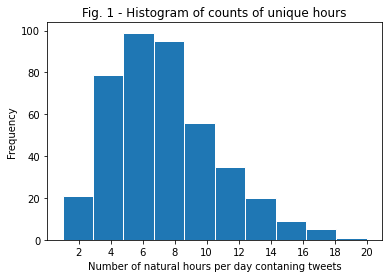

In [145]:
#transforming to pandas for the histogram 
plt.hist(hourlyPerDay.toPandas()['uniqueHourCount'], bins=10, edgecolor='white')

#Arranging axis labels, ticks, title
plt.xlabel('Number of natural hours per day contaning tweets')
plt.ylabel('Frequency')
plt.xticks(np.arange(2,21,2))
plt.title('Fig. 1 - Histogram of counts of unique hours')

plt.show()

## Basic plots

In [134]:
from pyspark.sql.functions import dayofweek, month, hour, count

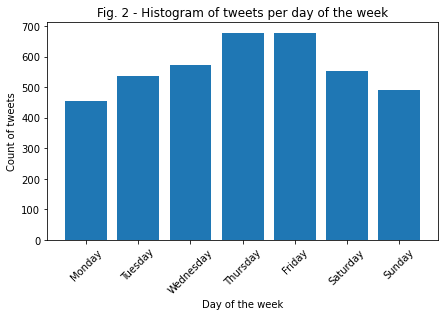

In [144]:
#extracting each of the days of the week
tweets= tweets.withColumn('day_of_week', dayofweek('created_at'))

# counting number of tweets by day of the week by adding a new column
tweetCounts= tweets.groupBy('day_of_week').agg(count('*').alias('count'))


dayLabels= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(7, 4))#setting size of plot
plt.bar(tweetCounts.toPandas()['day_of_week'], tweetCounts.toPandas()['count'])#need to convert to pandas

#Arranging axis labels, ticks, title
plt.xlabel('Day of the week')
plt.ylabel('Count of tweets')
plt.title('Fig. 2 - Histogram of tweets per day of the week')
plt.xticks(range(1, 8), dayLabels, rotation=45)
plt.show()

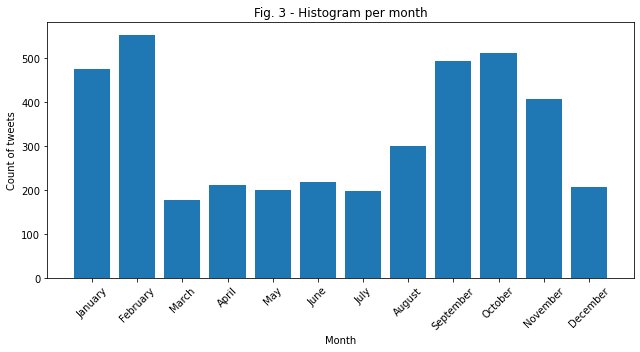

In [146]:
# extracting months
tweets= tweets.withColumn('month', month('created_at'))

#same as before adding a new column with counts
tweetCounts= tweets.groupBy('month').agg(count('*').alias('count'))



monthLabels= ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']


plt.figure(figsize=(9, 5))
plt.bar(tweetCounts.toPandas()['month'], tweetCounts.toPandas()['count'])
plt.xlabel('Month')
plt.ylabel('Count of tweets')
plt.title('Fig. 3 - Histogram per month')
plt.xticks(range(1, 13), monthLabels,rotation=45)
plt.tight_layout()
plt.show()

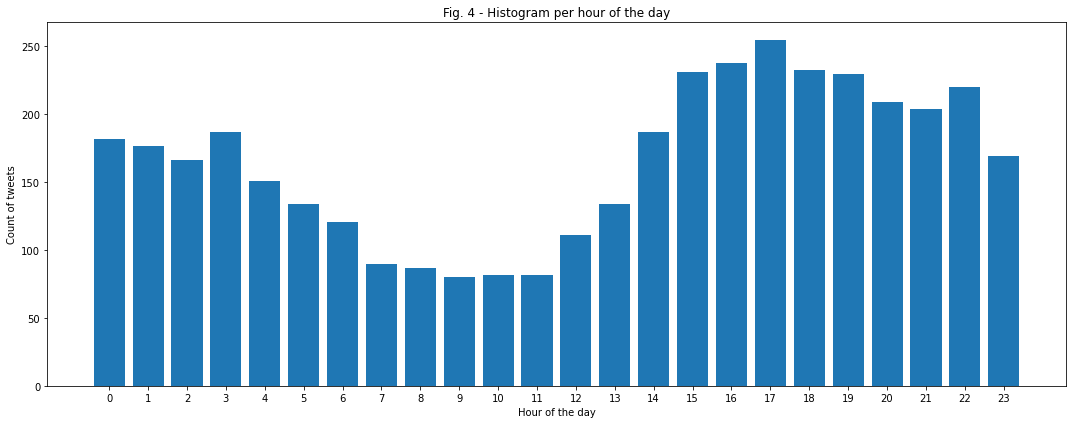

In [148]:
#extracting each of the 24 hours of a day
tweets= tweets.withColumn('hour_of_day', hour('created_at'))

#adding column with counts
tweetCounts= tweets.groupBy('hour_of_day').agg(count('*').alias('count'))


plt.figure(figsize=(15, 6))
plt.bar(tweetCounts.toPandas()['hour_of_day'], tweetCounts.toPandas()['count'])
plt.xlabel('Hour of the day')
plt.ylabel('Count of tweets')
plt.title('Fig. 4 - Histogram per hour of the day')
plt.xticks(range(24))
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import string
from string import punctuation
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
!pip install nltk